In [1]:
from hossam import load_data

In [16]:
# insurance = load_data('insurance')
origin = load_data('insurance')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
origin.info()

# origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


===== 데이터 크기 확인 =====
데이터셋 크기 : (1338, 7)
열 개수: 7
행 개수: 1338

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null

범주형 변수 카테고리로 변경

In [27]:
df = origin.copy()
df = df.astype({'sex': 'category', 'smoker': 'category', 'region': 'category'})
# df.info()
df['region'].unique()

['southwest', 'southeast', 'northwest', 'northeast']
Categories (4, object): ['northeast', 'northwest', 'southeast', 'southwest']

데이터 빈 값 확인
- 클-린

In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


범주형 변수 인코딩 적용

In [24]:
import pandas as pd
# 레이블 인코딩 (0,1,2,3)
sex_mapping = {'male':0, 'female': 1}
df['sex_encoded'] = df['sex'].replace(sex_mapping)

# 1-2. smoker 변수 매핑
smoker_mapping = {'no': 0, 'yes': 1}
df['smoker_encoded'] = df['smoker'].replace(smoker_mapping)
df = df.drop(columns=['sex', 'smoker'])

C:\Users\itwill\AppData\Local\Temp\ipykernel_3236\2965483654.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex_encoded'] = df['sex'].replace(sex_mapping)
C:\Users\itwill\AppData\Local\Temp\ipykernel_3236\2965483654.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['sex_encoded'] = df['sex'].replace(sex_mapping)
C:\Users\itwill\AppData\Local\Temp\ipykernel_3236\2965483654.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.in

In [29]:
from sklearn.preprocessing import OneHotEncoder
# region 변수에 원핫 인코딩 적용
df2 = df.copy()
df2 = pd.get_dummies(df, columns=['region'], drop_first=True, dtype='int')
df2

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,0,0,1
1,18,male,33.770,1,no,1725.55230,0,1,0
2,28,male,33.000,3,no,4449.46200,0,1,0
3,33,male,22.705,0,no,21984.47061,1,0,0
4,32,male,28.880,0,no,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830,1,0,0
1334,18,female,31.920,0,no,2205.98080,0,0,0
1335,18,female,36.850,0,no,1629.83350,0,1,0
1336,21,female,25.800,0,no,2007.94500,0,0,1


smoker, charge 추출 

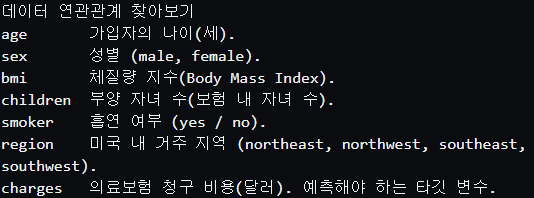

1. 가설설정
- 1. 담배피는 사람은 보험비가 높을 것이다. (흡연 여부가 보험비에 영향이 있을 것이다. or 흡연자와 비흡연자의 보험비는 차이가 존재한다.)
- 2. 자녀 수에 따라 보험비의 차이가 존재한다.
- 3. 거주지에 따라 보험비의 차이가 존재한다.
- 4. 특정 성별이면서 bmi지수가 높은 사람은 보험비가 높을 것이다. (성별+체질량 지수는 보험비에 영향을 끼친다.)
- 5. 나이가 들 수록 보험비는 비싸질 것이다. (나이는 보험비에 영향을 끼친다.)

#### 1. 담배 피는 사람은 보험비가 높을 것이다. 
- 독립변수 = 'smoker', 종속변수 = 'charges' 
- 귀무가설 : 흡연여부는 보험비에 영향을 주지 않는다.
- 대립가설 : 흡연여부는 보험비에 영향을 준다.

In [30]:
df3 = df2[['smoker','charges']]
df3.head()

,smoker,charges
0,yes,16884.92400
1,no,1725.55230
2,no,4449.46200
3,no,21984.47061
4,no,3866.85520


In [8]:
# 패키지 선언
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from math import sqrt
from pandas import DataFrame, melt
#가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind

#분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

#사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_gameshowell, pairwise_tests

In [9]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

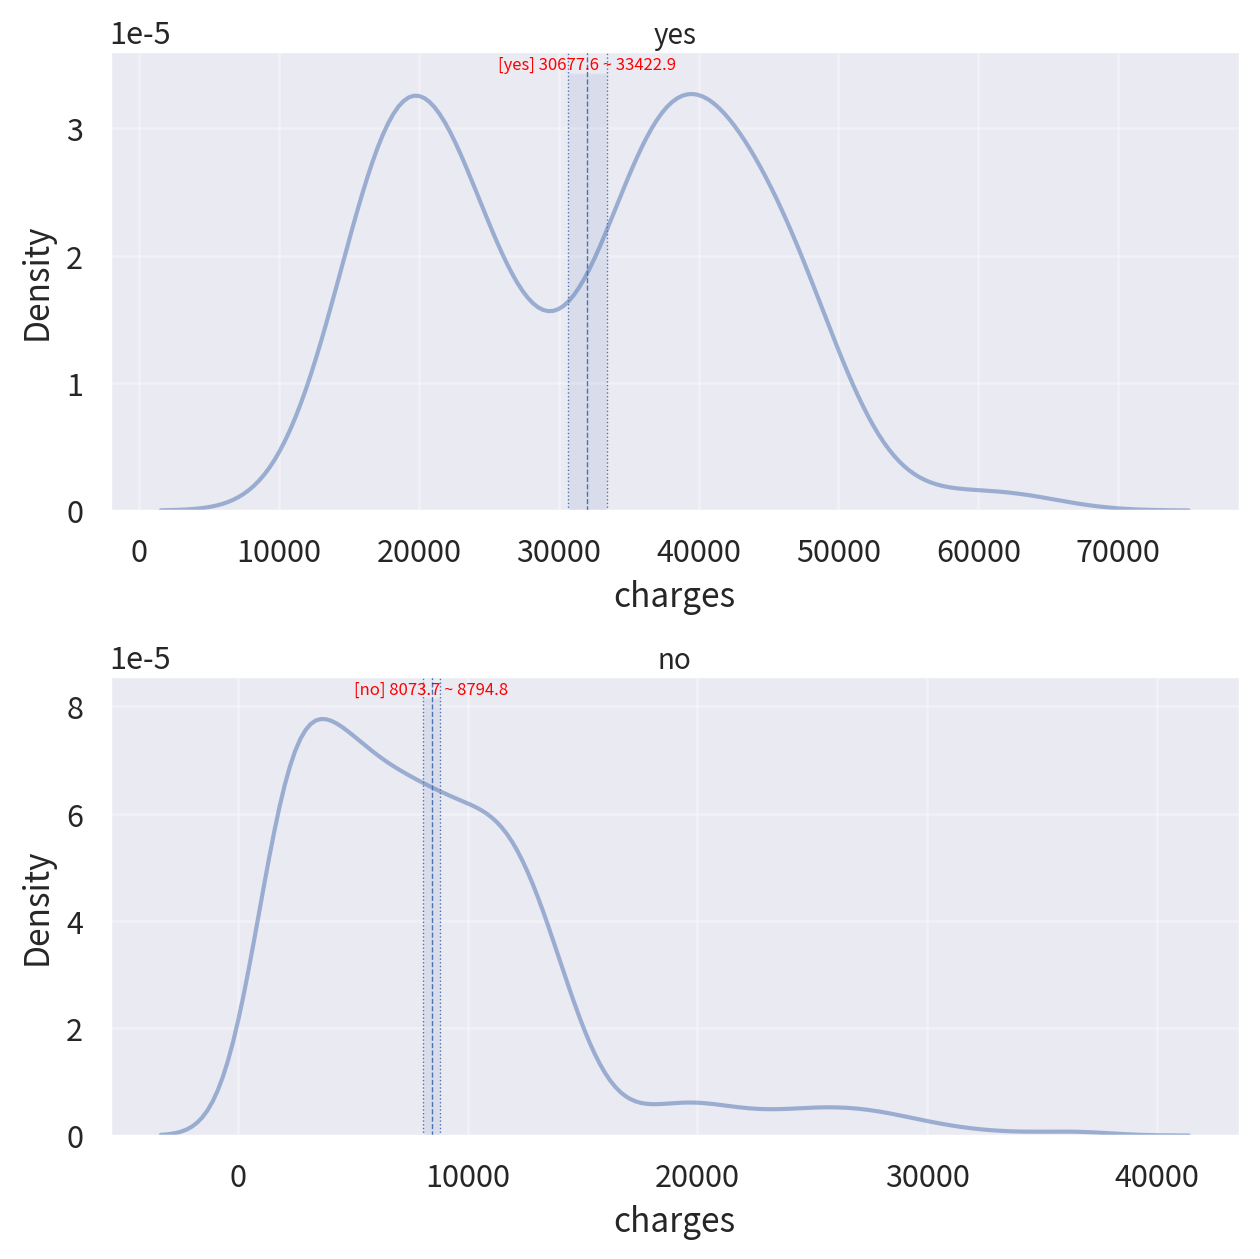

In [ ]:
field = 'charges'

hue_field = 'smoker'

hue_values = df3[hue_field].unique()

hue_count = len(hue_values)

# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280             #그래프 가로 크기
height_px = 640 * hue_count             #그래프 세로 크기
rows = hue_count                    #도화지의 행 수
cols = 1                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i,v in enumerate(hue_values):
    temp = df2[df2[hue_field]==v]
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize = 10, pad=3)

    # 신뢰구간
    max = temp[field].max()                         #최대값
    clevel = 0.95                               #신뢰수준
    dof = len(temp[field]) - 1                       #자유도
    sp_mean = temp[field].mean()                    #표본평균
    sp_std = temp[field].std(ddof = 1)           #표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) #표본표준오차
    cmin,cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    #평균 표시
    ymin,ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin,cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=0.5)

    #텍스트 그리기
    ax[i].text(x=(cmax-cmin)/2+cmin, y=ymax, s="[%s] %0.1f ~ %0.1f" %(v,cmin,cmax),
            horizontalalignment='center',
            verticalalignment='bottom', 
            fontdict={'size':6, 'color':'red'})

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 흡연자가 비흡연자에 비해 확연히 보험비가 높음.
- 흡연자의 경우 20000, 40000에 집중적으로 몰려있음을 알 수 있음.

In [11]:
load_data('boston')

[data] https://data.hossam.kr/data/kaggle/boston.xlsx
[desc] 보스턴 인근 지역의 인구·환경·교육·범죄·세금 정보 등을 기반으로 주택의 중위가격(MEDV)을 예측하기 위해 수집된 대표적인 회귀 분석용 주택시장 데이터 (출처: https://www.kaggle.com/datasets/altavish/boston-housing-dataset)

field    description
-------  ---------------------------------------------------------------------------------------
CRIM     타운별 1인당 범죄율 (Per capita crime rate by town)
ZN       25,000 sqft 이상 주거용 대지 비율 (Proportion of residential land zoned for large lots)
INDUS    비소매 상업구역 비율 (Proportion of non-retail business acres per town)
CHAS     찰스강 인접 여부 (Charles River dummy variable: 1 if tract bounds river; 0 otherwise)
NOX      대기 오염 정도 (Nitric oxides concentration, parts per 10 million)
RM       주택당 평균 방(Room) 수 (Average number of rooms per dwelling)
AGE      1940년 이전 건축 비율 (Proportion of owner-occupied units built prior to 1940)
DIS      5개 주요 고용센터까지의 거리 (Weighted distances to five Boston employment centers)
RAD      고속도로 접근성 지수 (Index of accessibility to radial highways)
T

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [12]:
load_data('california')

[data] https://data.hossam.kr/data/kaggle/california.xlsx
[desc] 1990년 미국 인구조사(Census)를 기반으로 캘리포니아 각 지역의 인구·주택·소득 특성과 주택 중위가격을 담아, 회귀 분석과 머신러닝 모델 실습에 널리 사용되는 대표적인 주택 가격 데이터 (출처: https://www.kaggle.com/datasets/camnugent/california-housing-prices)

field               description
------------------  ------------------------------------------------------------------------------
longitude           경도(Longitude). 서경(–값) 기준.
latitude            위도(Latitude). 북위(+) 기준.
housing_median_age  해당 구역(블록 그룹)의 주택 중위 연령(년).
total_rooms         구역 내 모든 주택의 총 방(room) 수 합계.
total_bedrooms      구역 내 모든 주택의 총 침실(bedroom) 수 합계.
population          구역의 전체 인구 수.
households          구역의 전체 “가구 수”(living units).
median_income       구역의 중위 소득(median income), 단위는 약 1 = $10,000 수준.
median_house_value  주택 중위가격(달러). 회귀의 목표변수(타깃).
ocean_proximity     해안과의 거리/접근성 범주: <1H OCEAN, INLAND, NEAR BAY, NEAR OCEAN, ISLAND 등.



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,78100,INLAND
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,77100,INLAND
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,92300,INLAND
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,84700,INLAND
